# Mnist Embeddings Visualization using Semi-Hard Triplet Loss
In this notebook, the mnist data-set will be passed into an embedding network that is trained via tensorflow-addons semi-hard triplet loss. pricipale-component-analysis **PCA** will be used to visualize the 64-dimension embedding vector into 2D-space. The embeddings is plotted before each epoch to monitor how the triplet-loss affects the embeddings of the same class to be pulled towards each other, and the dissimilar classes to be pushed away from each other.

Install tensorflow-addons. 

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1MB 4.7MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

train_dataset, test_dataset = tfds.load(name="mnist", split=['train', 'test'], as_supervised=True)

# Build your input pipelines
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.map(_normalize_img)

test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.map(_normalize_img)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [4]:

def Embedding_network(input_shape, embedding_size):
    """
    Base network to be shared (eq. to feature extraction).
    """
    embedding_network = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(embedding_size, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

    ])
    embedding_network.summary()
    return embedding_network


In [22]:
image_shape=(28,28,1)
embedding_network = Embedding_network(image_shape,64)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1568)             

In [23]:
embedding_network.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tfa.losses.TripletSemiHardLoss())


In [17]:
numpy_images = np.zeros((32, 28, 28, 1))
numpy_labels = np.zeros((16,))
i=0
for images, labels in test_dataset.take(-1):  # only take first element of dataset
    if(i==0):
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      i+=1
    else:
      numpy_images = np.concatenate((numpy_images, images.numpy()), axis=0)
      numpy_labels = np.concatenate((numpy_labels, labels.numpy()), axis=0)

In [24]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
      # use the model to predict
      x_embeddings = self.model.predict(np.reshape(numpy_images, (len(numpy_images), 28, 28, 1)))
      # apply PCA on the predicted embeddings
      pca = PCA(n_components=2)
      pca_embeddings = pca.fit_transform(x_embeddings)
      # prepare the classes labels
      test_class_labels = np.unique(np.array(numpy_labels))
      # create the figure
      fig = plt.figure(figsize=(16, 8))
      for label in test_class_labels:
          pca_embeddings_class = pca_embeddings[numpy_labels == label]
          plt.scatter(pca_embeddings_class[::5, 1], pca_embeddings_class[::5, 0],label=str(label))
          plt.title('after @%d epochs' % epoch)
      plt.savefig('epoch'+str(epoch)+'.png')
      plt.close() 

    def on_train_begin(self, logs=None):
      # use the model to predict
      x_embeddings = self.model.predict(np.reshape(numpy_images, (len(numpy_images), 28, 28, 1)))
      # apply PCA on the predicted embeddings
      pca = PCA(n_components=2)
      pca_embeddings = pca.fit_transform(x_embeddings)
      # prepare the classes labels
      test_class_labels = np.unique(np.array(numpy_labels))
      # create the figure
      fig = plt.figure(figsize=(16, 8))
      for label in test_class_labels:
          pca_embeddings_class = pca_embeddings[numpy_labels == label]
          plt.scatter(pca_embeddings_class[::5, 1], pca_embeddings_class[::5, 0],label=str(label))
          plt.title('Embeddings before training')
          plt.legend()
      plt.savefig('Embeddings before training.png')
      plt.show()
      plt.close() 


    def on_train_end(self, logs=None):
      # use the model to predict
      x_embeddings = self.model.predict(np.reshape(numpy_images, (len(numpy_images), 28, 28, 1)))
      # apply PCA on the predicted embeddings
      pca = PCA(n_components=2)
      pca_embeddings = pca.fit_transform(x_embeddings)
      # prepare the classes labels
      test_class_labels = np.unique(np.array(numpy_labels))
      # create the figure
      fig = plt.figure(figsize=(16, 8))
      for label in test_class_labels:
          pca_embeddings_class = pca_embeddings[numpy_labels == label]
          plt.scatter(pca_embeddings_class[::5, 1], pca_embeddings_class[::5, 0],label=str(label))
          plt.title('Embeddings after training')
          plt.legend()
      plt.savefig('Embeddings after training.png')
      plt.show()
      plt.close() 




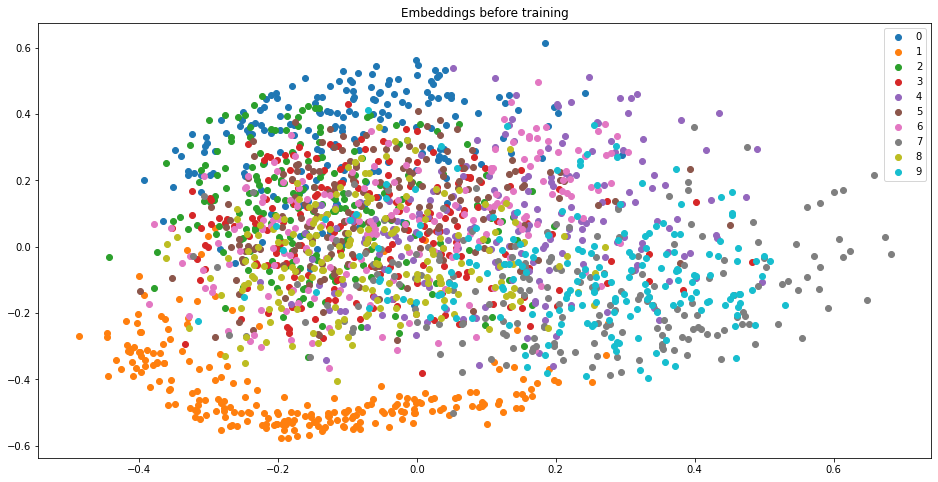

Epoch 1/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.8422
Epoch 2/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6731
Epoch 3/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5917
Epoch 4/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5376
Epoch 5/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.5016
Epoch 6/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4743
Epoch 7/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4537
Epoch 8/50
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4384
Epoch 9/50
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4259
Epoch 10/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4175
Epoch 11/50
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4084
Epoch 12/50
1875/1875 [==============================] - 12s 7ms/step - lo

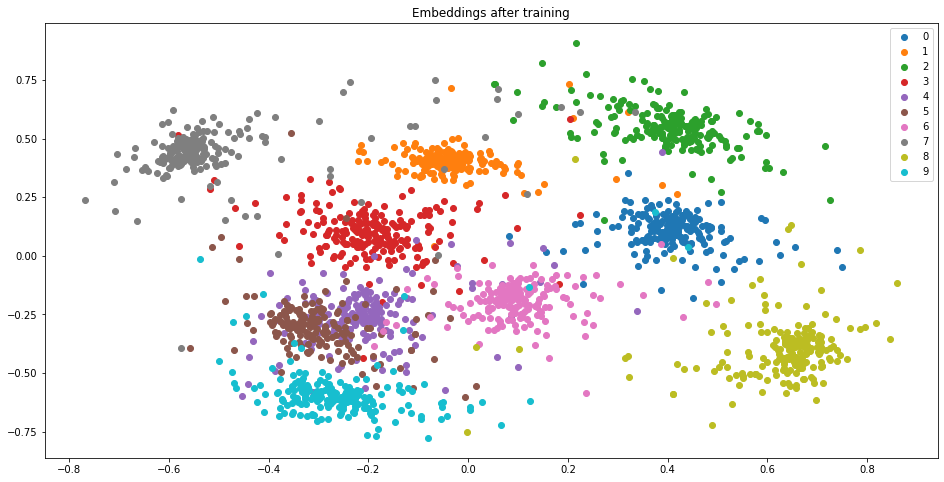

In [25]:
# Train the network
history = embedding_network.fit(
    train_dataset,
    epochs=50,
    callbacks=[CustomCallback()],
    )

In [26]:
! pip install imageio

In [40]:
import os
import imageio

files = ['epoch'+str(i)+'.png' for i in range(50)]

images = [imageio.imread(file) for file in files]
imageio.mimwrite('Embeddings_over_training.gif', images, fps=2)


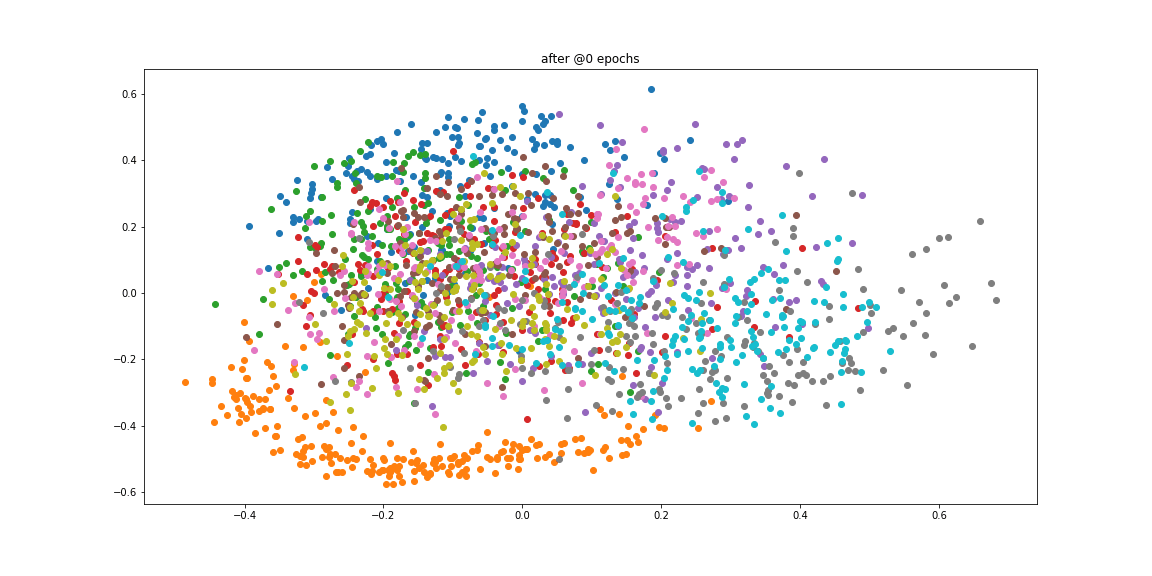

In [41]:
from IPython.display import display, Image

with open('Embeddings_over_training.gif','rb') as f:
    display(Image(data=f.read(), format='png'))
